In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

In [2]:
df = pd.read_csv("/kaggle/input/prepossessed-arrays-of-binary-data/1000_Binary Dataframe")
df.head(n=5)

,Unnamed: 0,exists,eye_side,level,path,patient_id,level_cat
0,0,True,left,0,../input/diabetic-retinopathy-detection/10_lef...,10,[1. 0.]
1,1,True,right,0,../input/diabetic-retinopathy-detection/10_rig...,10,[1. 0.]
2,2,True,left,0,../input/diabetic-retinopathy-detection/13_lef...,13,[1. 0.]
3,3,True,right,0,../input/diabetic-retinopathy-detection/13_rig...,13,[1. 0.]
4,8,True,left,0,../input/diabetic-retinopathy-detection/17_lef...,17,[1. 0.]


In [3]:
df.shape

(1000, 7)

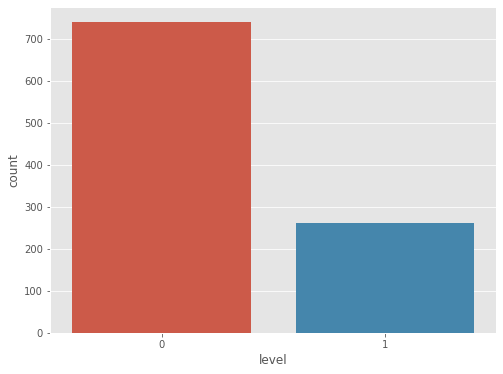

In [4]:
plt.style.use("ggplot")
plt.figure(figsize=(8,6))
sns.countplot(data=df,x = 'level')
plt.show()

In [5]:
images_264 = np.load('../input/prepossessed-arrays-of-binary-data/1000_Binary_images_data_264.npz')
X_264=images_264['a']
y=df['level'].values


print(X_264.shape)
print(y.shape)

(1000, 209088)
(1000,)


In [6]:
print("Shape before reshaping X_264" +str(X_264.shape))
X_264=X_264.reshape(1000,264,264,3)
print("Shape after reshaping X_264" +str(X_264.shape))

Shape before reshaping X_264(1000, 209088)
Shape after reshaping X_264(1000, 264, 264, 3)


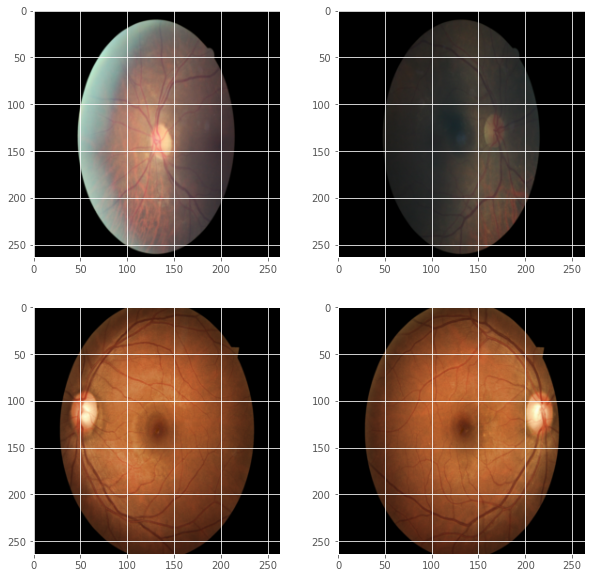

In [7]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.imshow(X_264[0])
plt.subplot(2,2,2)
plt.imshow(X_264[1])
plt.subplot(2,2,3)
plt.imshow(X_264[2])
plt.subplot(2,2,4)
plt.imshow(X_264[3])
plt.show()

In [8]:
from keras.models import load_model
import cv2
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras import backend as K
from keras.utils import CustomObjectScope


def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + 1e-15) / (union + 1e-15)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)


with CustomObjectScope({'iou': iou,'dice_coef': dice_coef, 'dice_loss': dice_loss}):
        model = tf.keras.models.load_model("../input/dr-model-2/model2.h5")
X_seg = []    
for i in X_264:
    z = i
    scale_percent = 194 # percent of original size
    width = int(z.shape[1] * scale_percent / 100)
    height = int(z.shape[0] * scale_percent / 100)
    dim = (width, height)

    resized = cv2.resize(z, dim, interpolation = cv2.INTER_AREA)
#     X_512 = np.append(X_512,np.array(resized))
    x = resized.astype(np.float32)
    prediction = model.predict(np.expand_dims(x, axis=0))[0]
    scale_percent = 100 # percent of original size
    width = int(z.shape[1] * scale_percent / 100)
    height = int(z.shape[0] * scale_percent / 100)
    dim = (width, height)

    resized = cv2.resize(z, dim, interpolation = cv2.INTER_AREA)
    
    X_seg.append(resized)

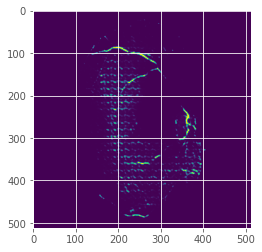

In [9]:
plt.imshow(prediction)

In [10]:
X=np.array(X_264)
Y=np.array(y)
Y=to_categorical(Y,2)
x_train, x_test1, y_train, y_test1 = train_test_split(X, Y, test_size=0.3, random_state=42)
x_test, x_val, y_test, y_val = train_test_split(x_test1, y_test1, test_size=0.4, random_state=101)
print(len(x_train),len(x_val),len(x_test))

700 120 180


In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [12]:
augment = ImageDataGenerator( 
                             rotation_range=20,
                              width_shift_range=0.01, 
                              height_shift_range=0.01, 
                              horizontal_flip=False, 
                              vertical_flip=False,
                            )
augment.fit(x_train)

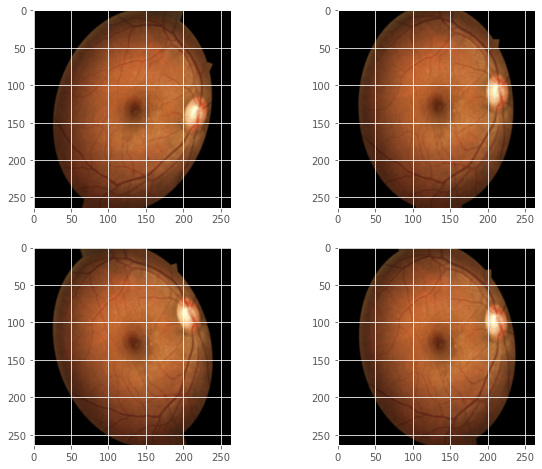

In [13]:
plt.figure(figsize=(10,8))
plt.subplot(2,2,1)
plt.imshow(augment.random_transform(X_264[3]))
plt.subplot(2,2,2)
plt.imshow(augment.random_transform(X_264[3]))
plt.subplot(2,2,3)
plt.imshow(augment.random_transform(X_264[3]))
plt.subplot(2,2,4)
plt.imshow(augment.random_transform(X_264[3]))
plt.show()

In [14]:
model = ResNet50(include_top = False,weights = 'imagenet',input_shape = (264,264,3))

94773248/94765736 [==============================] - 0s 0us/step


In [15]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 264, 264, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 270, 270, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 132, 132, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 132, 132, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [16]:
for ix in range(len(model.layers)):
    print(ix,model.layers[ix])

0 <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f6df0107750>
1 <tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x7f6df0107950>
2 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6dde66fc50>
3 <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f6ddde82610>
4 <tensorflow.python.keras.layers.core.Activation object at 0x7f6dde645510>
5 <tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x7f6dde649150>
6 <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f6dde63ffd0>
7 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6dde63f5d0>
8 <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f6dde64acd0>
9 <tensorflow.python.keras.layers.core.Activation object at 0x7f6dde796210>
10 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6dde64a310>
11 <tensorflow.python.keras.layers.normalization_v2.BatchNormalization o

In [17]:
for layer in model.layers[:169]:
    layer.trainable = False
for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.trainable)

0 input_1 False
1 conv1_pad False
2 conv1_conv False
3 conv1_bn False
4 conv1_relu False
5 pool1_pad False
6 pool1_pool False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_conv False
11 conv2_block1_2_bn False
12 conv2_block1_2_relu False
13 conv2_block1_0_conv False
14 conv2_block1_3_conv False
15 conv2_block1_0_bn False
16 conv2_block1_3_bn False
17 conv2_block1_add False
18 conv2_block1_out False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_conv False
23 conv2_block2_2_bn False
24 conv2_block2_2_relu False
25 conv2_block2_3_conv False
26 conv2_block2_3_bn False
27 conv2_block2_add False
28 conv2_block2_out False
29 conv2_block3_1_conv False
30 conv2_block3_1_bn False
31 conv2_block3_1_relu False
32 conv2_block3_2_conv False
33 conv2_block3_2_bn False
34 conv2_block3_2_relu False
35 conv2_block3_3_conv False
36 conv2_block3_3_bn False
37 conv2_block3_add False
38 conv2_bloc

In [18]:
av1 = Flatten()(model.output)
fc1 = Dense(256,activation='relu',kernel_regularizer= l2(0.01),input_dim=256)(av1)
d1 = Dropout(0.5)(fc1)
fc2 = Dense(128,activation='relu',kernel_regularizer= l2(0.01),input_dim=128)(d1)
d2 = Dropout(0.5)(fc2)
fc3 = Dense(2,activation = 'sigmoid')(d2)


model_resnet = Model(model.input,fc3)
model_resnet.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 264, 264, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 270, 270, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 132, 132, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 132, 132, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [19]:
adam = Adam(learning_rate=0.0001)
model_resnet.compile(loss='binary_crossentropy',optimizer = adam,metrics=['accuracy'])

In [20]:
filepath="retina_resnet50.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=2, save_best_only=True, mode='min',patience=2)
callbacks_list = [checkpoint]

In [21]:
hist2 = model_resnet.fit(x_train,y_train,
                    shuffle = True,
                    batch_size=32,
                    epochs = 40,
                    validation_data=(x_val,y_val),callbacks=callbacks_list)

Epoch 1/40
22/22 [==============================] - 8s 207ms/step - loss: 7.5165 - accuracy: 0.6121 - val_loss: 4.0216 - val_accuracy: 0.7417

Epoch 00001: val_loss improved from inf to 4.02161, saving model to retina_resnet50.hdf5
Epoch 2/40
22/22 [==============================] - 2s 109ms/step - loss: 3.7848 - accuracy: 0.6116 - val_loss: 2.9178 - val_accuracy: 0.7417

Epoch 00002: val_loss improved from 4.02161 to 2.91780, saving model to retina_resnet50.hdf5
Epoch 3/40
22/22 [==============================] - 2s 115ms/step - loss: 2.8739 - accuracy: 0.6419 - val_loss: 2.6525 - val_accuracy: 0.7417

Epoch 00003: val_loss improved from 2.91780 to 2.65255, saving model to retina_resnet50.hdf5
Epoch 4/40
22/22 [==============================] - 3s 116ms/step - loss: 2.6502 - accuracy: 0.6234 - val_loss: 2.5319 - val_accuracy: 0.7417

Epoch 00004: val_loss improved from 2.65255 to 2.53187, saving model to retina_resnet50.hdf5
Epoch 5/40
22/22 [==============================] - 2s 113ms

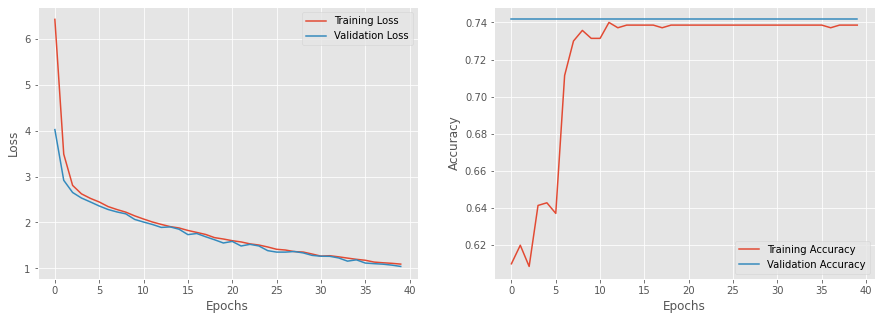

In [22]:
plt.figure(1, figsize = (15, 5))
plt.subplot(1,2,1)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot( hist2.history["loss"], label = "Training Loss")
plt.plot( hist2.history["val_loss"], label = "Validation Loss")
plt.grid(True)
plt.legend()

plt.subplot(1,2,2)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot( hist2.history["accuracy"], label = "Training Accuracy")
plt.plot( hist2.history["val_accuracy"], label = "Validation Accuracy")
plt.grid(True)
plt.legend()
plt.show()

In [23]:
model_resnet.evaluate(x_test,y_test)

6/6 [==============================] - 1s 138ms/step - loss: 1.0469 - accuracy: 0.7389


[1.0469475984573364, 0.7388888597488403]

In [24]:
predictions = model_resnet.predict(x_test, batch_size = 32)
pred2 = np.argmax(predictions, axis=1)
y_test2 = np.argmax(y_test, axis=1)

In [25]:
print(classification_report(y_test2, pred2))


              precision    recall  f1-score   support

           0       0.74      1.00      0.85       133
           1       0.00      0.00      0.00        47

    accuracy                           0.74       180
   macro avg       0.37      0.50      0.42       180
weighted avg       0.55      0.74      0.63       180



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [26]:
print(confusion_matrix(y_test2, pred2))

[[133   0]
 [ 47   0]]


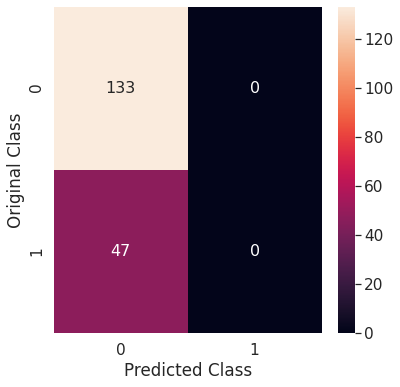

In [27]:
plt.figure(figsize=(6,6))
df_cm2 = pd.DataFrame(confusion_matrix(y_test2, pred2), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm2, annot=True,annot_kws={"size": 16}, fmt='g')
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()

In [28]:
y_pred_keras2 = model_resnet.predict(x_test).ravel()

In [29]:
from sklearn.metrics import roc_curve

fpr_keras2, tpr_keras2, thresholds_keras2 = roc_curve(y_test2, pred2)

In [30]:
from sklearn.metrics import auc
auc_keras2 = auc(fpr_keras2, tpr_keras2)

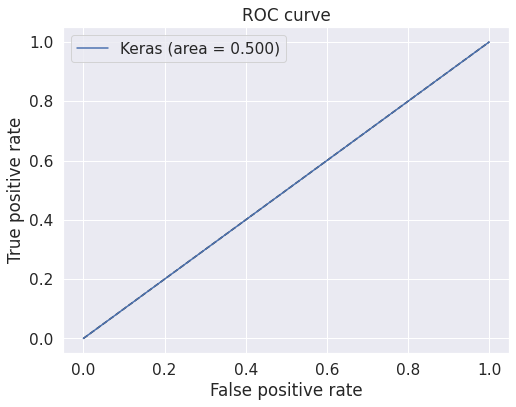

In [31]:
plt.figure(figsize=(8,6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras2, tpr_keras2, label='Keras (area = {:.3f})'.format(auc_keras2))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [32]:
model1 = InceptionV3(include_top = False,weights = 'imagenet',input_shape = (264,264,3))

87916544/87910968 [==============================] - 0s 0us/step


In [33]:
model1.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 264, 264, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 131, 131, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 131, 131, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 131, 131, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [34]:
for ix in range(len(model1.layers)):
    print(ix,model1.layers[ix])

0 <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f6d92a9dc10>
1 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6df01074d0>
2 <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f6ddc17e250>
3 <tensorflow.python.keras.layers.core.Activation object at 0x7f6ddc05d550>
4 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6ddc06bbd0>
5 <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f6ddc042090>
6 <tensorflow.python.keras.layers.core.Activation object at 0x7f6d92aa5b90>
7 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6ddc097ad0>
8 <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f6ddc067250>
9 <tensorflow.python.keras.layers.core.Activation object at 0x7f6d92abe110>
10 <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f6d92ac0e90>
11 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6ddc09

In [35]:
for layer in model1.layers[:299]:
    layer.trainable = False
for i, layer in enumerate(model1.layers):
    print(i, layer.name, layer.trainable)

0 input_2 False
1 conv2d False
2 batch_normalization False
3 activation False
4 conv2d_1 False
5 batch_normalization_1 False
6 activation_1 False
7 conv2d_2 False
8 batch_normalization_2 False
9 activation_2 False
10 max_pooling2d False
11 conv2d_3 False
12 batch_normalization_3 False
13 activation_3 False
14 conv2d_4 False
15 batch_normalization_4 False
16 activation_4 False
17 max_pooling2d_1 False
18 conv2d_8 False
19 batch_normalization_8 False
20 activation_8 False
21 conv2d_6 False
22 conv2d_9 False
23 batch_normalization_6 False
24 batch_normalization_9 False
25 activation_6 False
26 activation_9 False
27 average_pooling2d False
28 conv2d_5 False
29 conv2d_7 False
30 conv2d_10 False
31 conv2d_11 False
32 batch_normalization_5 False
33 batch_normalization_7 False
34 batch_normalization_10 False
35 batch_normalization_11 False
36 activation_5 False
37 activation_7 False
38 activation_10 False
39 activation_11 False
40 mixed0 False
41 conv2d_15 False
42 batch_normalization_15 False

In [36]:
av1 = Flatten()(model1.output)
fc1 = Dense(256,activation='relu',kernel_regularizer= l2(0.01),input_dim=256)(av1)
d1 = Dropout(0.5)(fc1)
fc2 = Dense(128,activation='relu',kernel_regularizer= l2(0.01),input_dim=128)(d1)
d2 = Dropout(0.5)(fc2)
fc3 = Dense(2,activation = 'sigmoid')(d2)


model_incep = Model(model1.input,fc3)
model_incep.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 264, 264, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 131, 131, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 131, 131, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 131, 131, 32) 0           batch_normalization[0][0]        
____________________________________________________________________________________________

In [37]:
adam = Adam(learning_rate=0.0001)
model_incep.compile(loss='binary_crossentropy',optimizer = adam,metrics=['accuracy'])

In [38]:
filepath="retina_incep.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=2, save_best_only=True, mode='min',patience=2)
callbacks_list = [checkpoint]

In [39]:
hist3 = model_incep.fit(x_train,y_train,
                    shuffle = True,
                    batch_size=32,
                    epochs = 40,
                    validation_data=(x_val,y_val),callbacks=callbacks_list)

Epoch 1/40
22/22 [==============================] - 9s 182ms/step - loss: 7.6903 - accuracy: 0.6718 - val_loss: 6.5182 - val_accuracy: 0.7667

Epoch 00001: val_loss improved from inf to 6.51818, saving model to retina_incep.hdf5
Epoch 2/40
22/22 [==============================] - 2s 82ms/step - loss: 6.5206 - accuracy: 0.6557 - val_loss: 5.7338 - val_accuracy: 0.7417

Epoch 00002: val_loss improved from 6.51818 to 5.73381, saving model to retina_incep.hdf5
Epoch 3/40
22/22 [==============================] - 2s 83ms/step - loss: 5.6336 - accuracy: 0.6965 - val_loss: 5.1559 - val_accuracy: 0.7500

Epoch 00003: val_loss improved from 5.73381 to 5.15589, saving model to retina_incep.hdf5
Epoch 4/40
22/22 [==============================] - 2s 80ms/step - loss: 5.1001 - accuracy: 0.7144 - val_loss: 4.7268 - val_accuracy: 0.7417

Epoch 00004: val_loss improved from 5.15589 to 4.72684, saving model to retina_incep.hdf5
Epoch 5/40
22/22 [==============================] - 2s 81ms/step - loss: 4.

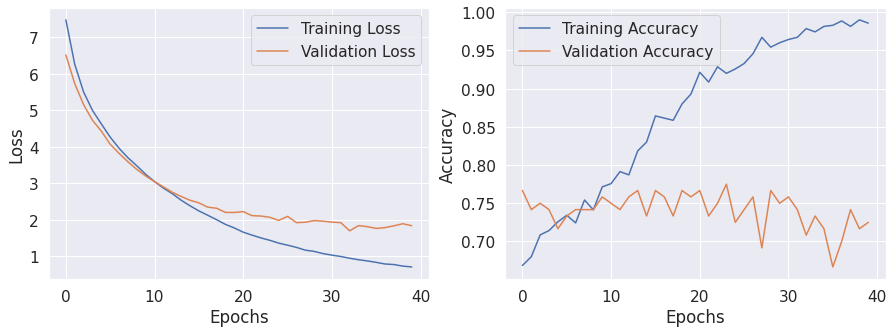

In [40]:
plt.figure(1, figsize = (15, 5))
plt.subplot(1,2,1)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot( hist3.history["loss"], label = "Training Loss")
plt.plot( hist3.history["val_loss"], label = "Validation Loss")
plt.grid(True)
plt.legend()

plt.subplot(1,2,2)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot( hist3.history["accuracy"], label = "Training Accuracy")
plt.plot( hist3.history["val_accuracy"], label = "Validation Accuracy")
plt.grid(True)
plt.legend()

In [41]:
model_incep.evaluate(x_test,y_test)

6/6 [==============================] - 1s 128ms/step - loss: 2.0743 - accuracy: 0.7444


[2.07433819770813, 0.7444444298744202]

In [42]:
predictions3 = model_incep.predict(x_test, batch_size = 32)
pred3 = np.argmax(predictions3, axis=1)
y_test3 = np.argmax(y_test, axis=1)

In [43]:
print(classification_report(y_test3, pred3))

              precision    recall  f1-score   support

           0       0.77      0.93      0.84       133
           1       0.53      0.21      0.30        47

    accuracy                           0.74       180
   macro avg       0.65      0.57      0.57       180
weighted avg       0.71      0.74      0.70       180



In [44]:
print(confusion_matrix(y_test3, pred3))

[[124   9]
 [ 37  10]]


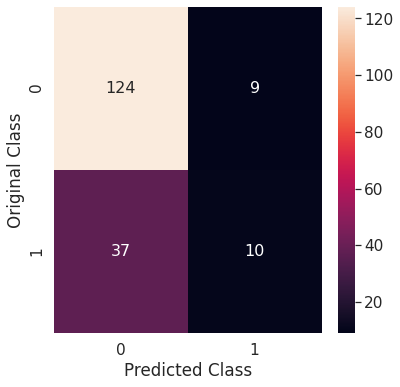

In [45]:
plt.figure(figsize=(6,6))
df_cm3 = pd.DataFrame(confusion_matrix(y_test3, pred3), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm3, annot=True,annot_kws={"size": 16}, fmt='g')
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()

In [46]:
y_pred_keras3 = model_incep.predict(x_test).ravel()

In [47]:
from sklearn.metrics import roc_curve

fpr_keras3, tpr_keras3, thresholds_keras3 = roc_curve(y_test3, pred3)

In [48]:
from sklearn.metrics import auc
auc_keras3 = auc(fpr_keras3, tpr_keras3)

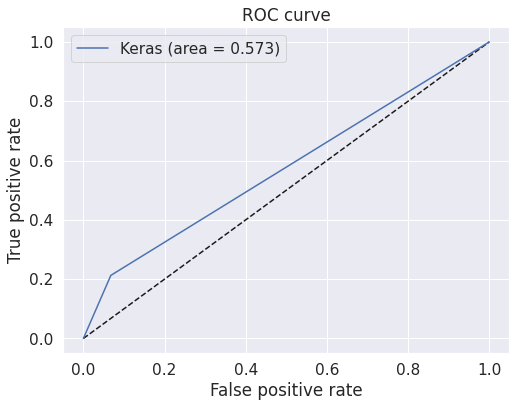

In [49]:
plt.figure(figsize=(8,6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras3, tpr_keras3, label='Keras (area = {:.3f})'.format(auc_keras3))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [50]:
model2 = VGG16(include_top = False,weights = 'imagenet',input_shape = (264,264,3))

58892288/58889256 [==============================] - 0s 0us/step


In [51]:
model2.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 264, 264, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 264, 264, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 264, 264, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 132, 132, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 132, 132, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 132, 132, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 66, 66, 128)       0     

In [52]:
for ix in range(len(model2.layers)):
    print(ix,model2.layers[ix])

0 <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f6841204090>
1 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f68412048d0>
2 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f68412743d0>
3 <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f6d640e5ed0>
4 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6841296990>
5 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6841279190>
6 <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f68411e1050>
7 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6841186690>
8 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f684119c350>
9 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f68412749d0>
10 <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f68411a2f10>
11 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f68411a7c50>
12 <tensorflow.python.ke

In [53]:
for layer in model2.layers[:16]:
    layer.trainable = False
for i, layer in enumerate(model2.layers):
    print(i, layer.name, layer.trainable)

0 input_3 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 False
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


In [54]:
av1 = Flatten()(model2.output)
fc1 = Dense(256,activation='relu',kernel_regularizer= l2(0.01),input_dim=256)(av1)
d1 = Dropout(0.5)(fc1)
fc2 = Dense(128,activation='relu',kernel_regularizer= l2(0.01),input_dim=128)(d1)
d2 = Dropout(0.5)(fc2)
fc3 = Dense(2,activation = 'sigmoid')(d2)

In [55]:
model_vgg16 = Model(model2.input,fc3)
model_vgg16.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 264, 264, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 264, 264, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 264, 264, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 132, 132, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 132, 132, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 132, 132, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 66, 66, 128)       0   

In [56]:
adam = Adam(learning_rate=0.0001)
model_vgg16.compile(loss='binary_crossentropy',optimizer = adam,metrics=['accuracy'])

In [57]:
filepath="retina_vgg16.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=2, save_best_only=True, mode='min',patience=2)
callbacks_list = [checkpoint]

In [58]:
hist1 = model_vgg16.fit(x_train,y_train,
                    shuffle = True,
                    batch_size=32,
                    epochs = 40,
                    validation_data=(x_val,y_val),callbacks=callbacks_list)

Epoch 1/40
22/22 [==============================] - 13s 423ms/step - loss: 7.0023 - accuracy: 0.7156 - val_loss: 5.6595 - val_accuracy: 0.7417

Epoch 00001: val_loss improved from inf to 5.65947, saving model to retina_vgg16.hdf5
Epoch 2/40
22/22 [==============================] - 3s 119ms/step - loss: 5.3355 - accuracy: 0.7251 - val_loss: 4.4280 - val_accuracy: 0.7417

Epoch 00002: val_loss improved from 5.65947 to 4.42802, saving model to retina_vgg16.hdf5
Epoch 3/40
22/22 [==============================] - 3s 124ms/step - loss: 4.1966 - accuracy: 0.7572 - val_loss: 3.6133 - val_accuracy: 0.7417

Epoch 00003: val_loss improved from 4.42802 to 3.61330, saving model to retina_vgg16.hdf5
Epoch 4/40
22/22 [==============================] - 3s 124ms/step - loss: 3.4710 - accuracy: 0.7414 - val_loss: 3.0817 - val_accuracy: 0.7417

Epoch 00004: val_loss improved from 3.61330 to 3.08174, saving model to retina_vgg16.hdf5
Epoch 5/40
22/22 [==============================] - 3s 123ms/step - los

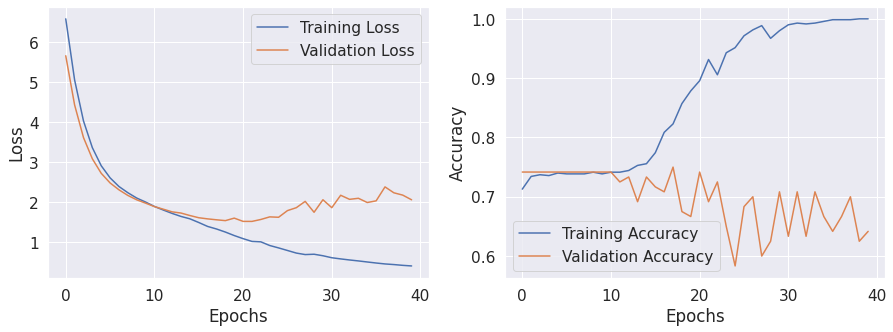

In [59]:
plt.figure(1, figsize = (15, 5))
plt.subplot(1,2,1)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot( hist1.history["loss"], label = "Training Loss")
plt.plot( hist1.history["val_loss"], label = "Validation Loss")
plt.grid(True)
plt.legend()

plt.subplot(1,2,2)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot( hist1.history["accuracy"], label = "Training Accuracy")
plt.plot( hist1.history["val_accuracy"], label = "Validation Accuracy")
plt.grid(True)
plt.legend()
plt.show()

In [60]:
model_vgg16.evaluate(x_test,y_test)

6/6 [==============================] - 3s 596ms/step - loss: 1.8935 - accuracy: 0.6333


[1.8934762477874756, 0.6333333253860474]

In [61]:
predictions = model_vgg16.predict(x_test, batch_size = 32)
pred1 = np.argmax(predictions, axis=1)
y_test1 = np.argmax(y_test, axis=1)

In [62]:
print(classification_report(y_test1, pred1))

              precision    recall  f1-score   support

           0       0.79      0.68      0.73       133
           1       0.35      0.49      0.41        47

    accuracy                           0.63       180
   macro avg       0.57      0.59      0.57       180
weighted avg       0.68      0.63      0.65       180



In [63]:
print(confusion_matrix(y_test1, pred1))

[[91 42]
 [24 23]]


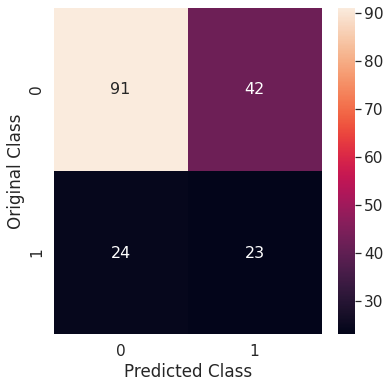

In [64]:
plt.figure(figsize=(6,6))
df_cm1 = pd.DataFrame(confusion_matrix(y_test1, pred1), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm1, annot=True,annot_kws={"size": 16}, fmt='g')
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()

In [65]:
y_pred_keras1 = model_vgg16.predict(x_test).ravel()

In [66]:
from sklearn.metrics import roc_curve

fpr_keras1, tpr_keras1, thresholds_keras1 = roc_curve(y_test1, pred1)

In [67]:
from sklearn.metrics import auc
auc_keras1 = auc(fpr_keras1, tpr_keras1)

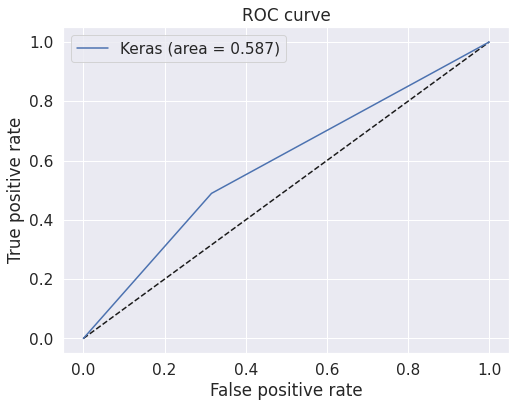

In [68]:
plt.figure(figsize=(8,6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras1, tpr_keras1, label='Keras (area = {:.3f})'.format(auc_keras1))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [69]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(264,264,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
    
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
    
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
    
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Dense(16, activation='relu'))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

In [16]:
c3=tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=2,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=0.001
)
model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy','AUC'])
history=model.fit(x_train,y_train,epochs=100,batch_size=16,validation_split=0.3)

Epoch 1/100
27/27 [==============================] - 5s 107ms/step - loss: 1.5293 - accuracy: 0.3962 - auc: 0.6713 - val_loss: 0.9601 - val_accuracy: 0.7556 - val_auc: 0.9439
Epoch 2/100
27/27 [==============================] - 2s 58ms/step - loss: 1.0698 - accuracy: 0.6189 - auc: 0.8578 - val_loss: 0.9468 - val_accuracy: 0.7556 - val_auc: 0.9389
Epoch 3/100
27/27 [==============================] - 1s 55ms/step - loss: 1.0463 - accuracy: 0.6378 - auc: 0.8660 - val_loss: 0.6834 - val_accuracy: 0.7556 - val_auc: 0.9392
Epoch 4/100
27/27 [==============================] - 1s 56ms/step - loss: 1.0567 - accuracy: 0.6375 - auc: 0.8593 - val_loss: 0.6251 - val_accuracy: 0.7556 - val_auc: 0.9391
Epoch 5/100
27/27 [==============================] - 1s 55ms/step - loss: 0.9565 - accuracy: 0.6521 - auc: 0.8833 - val_loss: 0.6192 - val_accuracy: 0.7556 - val_auc: 0.9387
Epoch 6/100
27/27 [==============================] - 1s 54ms/step - loss: 0.8765 - accuracy: 0.6835 - auc: 0.8987 - val_loss: 0.6

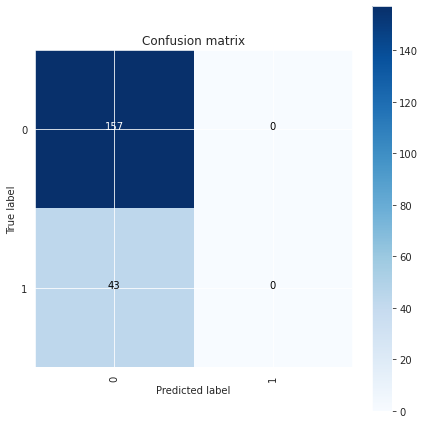

In [17]:
y_test=np.argmax(y_test, axis=1)
pred=np.argmax(model.predict(x_test),axis=-1)
cm=confusion_matrix(y_test,pred)
cm_plot=plot_confusion_matrix(cm,classes=['0','1'])

In [18]:
print("Performance Report:")
y_pred=np.argmax(model.predict(x_test),axis=-1)
Y_test=to_categorical(y_test,5)
y_pred_prb=model.predict(x_test)
target=['0','1']
from sklearn import metrics
print('Accuracy score is :', metrics.accuracy_score(y_test, y_pred))
print('Precision score is :', metrics.precision_score(y_test, y_pred, average='weighted'))
print('Recall score is :',metrics.recall_score(y_test,y_pred, average='weighted'))
print('F1 Score is :', metrics.f1_score(y_test, y_pred,average='weighted'))
print('Cohen Kappa Score:', metrics.cohen_kappa_score(y_test, y_pred))
print('\t\tClassification Report:\n', metrics.classification_report(y_test,pred,target_names=target))

Performance Report:
Accuracy score is : 0.934
Precision score is : 0.975935
Recall score is : 0.905
F1 Score is : 0.9095639573804752
Cohen Kappa Score: 0.0
		Classification Report:
               precision    recall  f1-score   support

           0       0.90      1.00      0.90       157
           1       0.00      0.00      0.00        43

    accuracy                           0.93       200
   macro avg       0.82      0.80      0.84       200
weighted avg       0.89      0.84      0.89       200



In [19]:
model.save_weights("model.h5")